# Short term Load Forcasting (Regression Machine Learning)

You have been provided with **Load Forecasting** data set as a single file, `dataset.csv`. 

We obtained it at http://www.mathworks.com/videos/electricity-load-and-price-forecasting-with-matlab-81765.html. 

For some background information you can also watch the video tutorial given in the link above:

Before you start on this notebook, copy the datasetset `dataset.csv` in the same directory.

### 1. Set up notebook and load dataset

In [2]:
!pip install -r requirement.txt

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import linear_model  # linear regression library
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


This next snippet of code loads the load forecasting dataset. There are 50000 data points, each with 8 predictor variables that are input `x` and one response variable (which we'll denote `y`).

Make sure the file `'dataset.csv'` is in the same directory as this notebook.

In [3]:
dataset = pd.read_csv('dataset.csv') # Reads the dataset in pandas dataframe

features = ['DryBulb', 'DewPoint', 'Hour', 'Weekday', 
            'IsWorkingDay', 'P_W_S_hour_l', 'P_D_S_hour_l', 'prev24HrAveLoad']
dataset.head() # This command tell the first 5 entries of the dataset

,DryBulb,DewPoint,Hour,Weekday,IsWorkingDay,P_W_S_hour_l,P_D_S_hour_l,prev24HrAveLoad,target_variable
0,37,25,1,5,0,12230,12230,509.583333,12230
1,37,25,2,5,0,11534,11534,990.166667,11534
2,39,24,3,5,0,11038,11038,1450.083333,11038
3,38,22,4,5,0,10777,10777,1899.125000,10777
4,37,20,5,5,0,10764,10764,2347.625000,10764


The dataset contains 8 input variable which contains the contextual information and historical load and temperature data. The variable includes:
- DryBulb temperature
- DewPoints
- Hours (data is collected in hourly samples so each day has 24 values)
- Weekday number [1 for Monday and 7 Sunday]
- Holyday flag [IsWorkingDay 0 for working 1 for holiday]
- prvious week same hour load (P_W_S_hour_l) 168 lagging entry i.e. 168 hours per week
- prevuous day same hour load (P_D_S_hour_l) 24 lagging entry
- prev24HrAveLoad (Average load for the perticular day)

Target variable is actual load at that perticular hour that is need to be predicted

# Statistical Feature Extraction (Increase the Feature Space)
This snippet of code extract the statistical features for the given data. These features includes the mean, standard deviation
and variance of daily, 48 hours, 72 hours and weekly load. 

In [4]:

dataset['weekly_rollingavg'] = dataset['target_variable'].rolling(window=168).mean()
dataset['weekly_std'] = dataset['target_variable'].rolling(window=168).std()
dataset['daily_std'] = dataset['target_variable'].rolling(window=24).std()

dataset['weekly_varience'] = dataset['target_variable'].rolling(window=168).var()
dataset['daily_varience'] = dataset['target_variable'].rolling(window=24).var()


dataset['weekly_median'] = dataset['target_variable'].rolling(window=168).median()
dataset['daily_meadian'] = dataset['target_variable'].rolling(window=24).median()



dataset['48_hour_mean'] = dataset['target_variable'].rolling(window=48).mean()
dataset['48_hour_variance'] = dataset['target_variable'].rolling(window=48).var()
dataset['48_hour_std'] = dataset['target_variable'].rolling(window=48).std()


dataset['72_hour_mean'] = dataset['target_variable'].rolling(window=72).mean()
dataset['72_hour_variance'] = dataset['target_variable'].rolling(window=72).var()
dataset['72_hour_std'] = dataset['target_variable'].rolling(window=72).std()


dataset['12_hours_temp_mean'] = dataset['DewPoint'].rolling(window=12).mean()
dataset['24_hour_temp_mean'] = dataset['DewPoint'].rolling(window=24).mean()


dataset['12_hours_temp_std'] = dataset['DewPoint'].rolling(window=12).std()
dataset['24_hour_temp_std'] = dataset['DewPoint'].rolling(window=24).std()


dataset['12_hours_temp_var'] = dataset['DewPoint'].rolling(window=12).var()
dataset['24_hour_temp_var'] = dataset['DewPoint'].rolling(window=24).var()




In [5]:
dataset.head() # Displays the first 5 values of expended dataset



,DryBulb,DewPoint,Hour,Weekday,IsWorkingDay,P_W_S_hour_l,P_D_S_hour_l,prev24HrAveLoad,target_variable,weekly_rollingavg,...,48_hour_std,72_hour_mean,72_hour_variance,72_hour_std,12_hours_temp_mean,24_hour_temp_mean,12_hours_temp_std,24_hour_temp_std,12_hours_temp_var,24_hour_temp_var
0,37,25,1,5,0,12230,12230,509.583333,12230,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37,25,2,5,0,11534,11534,990.166667,11534,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,39,24,3,5,0,11038,11038,1450.083333,11038,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,38,22,4,5,0,10777,10777,1899.125000,10777,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,37,20,5,5,0,10764,10764,2347.625000,10764,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
variables = [*dataset]

# The target_value is at index 8 so we have to remove it for the feature list.
#

index = 8
features = variables[:index]+variables[index+1:] # remove the target variable for feature list
print(features)

print('----------------------------------------------')

print('Number of features in training set:', len(features))



['DryBulb', 'DewPoint', 'Hour', 'Weekday', 'IsWorkingDay', 'P_W_S_hour_l', 'P_D_S_hour_l', 'prev24HrAveLoad', 'weekly_rollingavg', 'weekly_std', 'daily_std', 'weekly_varience', 'daily_varience', 'weekly_median', 'daily_meadian', '48_hour_mean', '48_hour_variance', '48_hour_std', '72_hour_mean', '72_hour_variance', '72_hour_std', '12_hours_temp_mean', '24_hour_temp_mean', '12_hours_temp_std', '24_hour_temp_std', '12_hours_temp_var', '24_hour_temp_var']
----------------------------------------------
Number of features in training set: 27


# Remove the missing value: (Data Filterig)

- While generating feature, the first few values of each column has NaN (not a number) which requires filtering before model training

In [7]:
count=0
for i in dataset.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
#print('Since it is only',round((count/len(dataset.index))*100), 'percent of the entire dataset the rows with missing values are excluded.')
dataset.isnull().sum()

Total number of rows with missing values is  167


DryBulb                 0
DewPoint                0
Hour                    0
Weekday                 0
IsWorkingDay            0
P_W_S_hour_l            0
P_D_S_hour_l            0
prev24HrAveLoad         0
target_variable         0
weekly_rollingavg     167
weekly_std            167
daily_std              23
weekly_varience       167
daily_varience         23
weekly_median         167
daily_meadian          23
48_hour_mean           47
48_hour_variance       47
48_hour_std            47
72_hour_mean           71
72_hour_variance       71
72_hour_std            71
12_hours_temp_mean     11
24_hour_temp_mean      23
12_hours_temp_std      11
24_hour_temp_std       23
12_hours_temp_var      11
24_hour_temp_var       23
dtype: int64

### Some of the features have values that are need to be removed with NaN

In [8]:
# Removeing the NaN and checking the dataset set. This is the inital filtering of the data.
dataset_new=dataset.dropna().reset_index(drop=True)
dataset_new

,DryBulb,DewPoint,Hour,Weekday,IsWorkingDay,P_W_S_hour_l,P_D_S_hour_l,prev24HrAveLoad,target_variable,weekly_rollingavg,...,48_hour_std,72_hour_mean,72_hour_variance,72_hour_std,12_hours_temp_mean,24_hour_temp_mean,12_hours_temp_std,24_hour_temp_std,12_hours_temp_var,24_hour_temp_var
0,16,3,24,4,1,15138,14315,17191.29167,15138,14949.434524,...,2599.385582,16339.680556,7.472860e+06,2733.653165,4.083333,3.833333,1.164500,1.129319,1.356061,1.275362
1,15,0,1,5,1,12230,13415,17223.41667,14186,14961.077381,...,2553.601008,16377.763889,7.199145e+06,2683.122159,3.916667,3.625000,1.564279,1.345282,2.446970,1.809783
2,14,1,2,5,1,11534,12990,17255.37500,13757,14974.309524,...,2497.665642,16415.430556,6.893903e+06,2625.624384,3.833333,3.458333,1.696699,1.413573,2.878788,1.998188
3,13,0,3,5,1,11038,12832,17287.08333,13593,14989.517857,...,2435.017897,16452.902778,6.575451e+06,2564.264171,3.416667,3.291667,1.975225,1.573674,3.901515,2.476449
4,12,-1,4,5,1,10777,12866,17318.16667,13612,15006.392857,...,2369.876249,16490.458333,6.254651e+06,2500.930063,3.000000,3.083333,2.335497,1.791688,5.454545,3.210145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49828,58,53,4,2,1,9408,9990,13135.45833,10015,13613.904762,...,2034.082504,13330.888889,4.417174e+06,2101.707365,56.000000,58.458333,2.088932,3.050006,4.363636,9.302536
49829,57,53,5,2,1,9473,9972,13147.91667,10271,13618.654762,...,2029.024434,13332.916667,4.404285e+06,2098.638873,55.666667,58.125000,2.229282,3.193914,4.969697,10.201087
49830,56,52,6,2,1,9740,10171,13192.70833,11246,13627.619048,...,2009.196627,13335.916667,4.390921e+06,2095.452459,55.166667,57.750000,2.329000,3.365425,5.424242,11.326087
49831,56,52,7,2,1,10039,10539,13297.83333,13062,13645.613095,...,1986.807917,13338.444444,4.389044e+06,2095.004460,54.583333,57.375000,2.151462,3.486776,4.628788,12.157609


In [9]:
count=0
for i in dataset_new.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
#print('Since it is only',round((count/len(dataset.index))*100), 'percent of the entire dataset the rows with missing values are excluded.')
dataset_new.isnull().sum()

Total number of rows with missing values is  0


DryBulb               0
DewPoint              0
Hour                  0
Weekday               0
IsWorkingDay          0
P_W_S_hour_l          0
P_D_S_hour_l          0
prev24HrAveLoad       0
target_variable       0
weekly_rollingavg     0
weekly_std            0
daily_std             0
weekly_varience       0
daily_varience        0
weekly_median         0
daily_meadian         0
48_hour_mean          0
48_hour_variance      0
48_hour_std           0
72_hour_mean          0
72_hour_variance      0
72_hour_std           0
12_hours_temp_mean    0
24_hour_temp_mean     0
12_hours_temp_std     0
24_hour_temp_std      0
12_hours_temp_var     0
24_hour_temp_var      0
dtype: int64

# Check the shape of the current dataset

In [10]:
print('The shape of the dataset:', dataset_new.shape)

# out of 28, 27 are the input variables which includes the statisitcal and contextual features

# the target value is the "target_variable" which is predicted using machine learning

# The 'target_variable' is the actual hourly load on substation level.

The shape of the dataset: (49833, 28)


# Preparing the Input and target values for model training

In [11]:
# Seperating the input and target variables for and converting them into numpy array.



input_features = np.array(dataset_new.drop('target_variable', axis=1))         # Features
target_values = np.array(dataset_new['target_variable'])                       # Output


print('Shape of the Input data:', input_features.shape)
print('Shape of the target variable:', target_values.shape)


print('Data type of the input features:', input_features.dtype)

Shape of the Input data: (49833, 27)
Shape of the target variable: (49833,)
Data type of the input features: float64


## Q1. Predict `y` using a single feature of `x`

Here we define a function, **one_feature_regression**, that takes `x` and `y`, along with the index `f` of a single feature and fits a linear regressor to `(x[f],y)`. It then plots the data along with the resulting line.

In [12]:
def one_feature_regression(x,y,f):

    '''
    x -> one inpu feature

    y -> Target value

    f -> index of feature
    '''


    if (f < 0) or (f > 26):            # Because the total number of features in this dataset are 27
        print("Feature index is out of bounds")
        return
    regr = linear_model.LinearRegression()          # simple linear regressing model y=mx + c  where y output, x input, m slope, c intesecpt.
    x1 = x[:,[f]]
    regr.fit(x1, y)
    # Make predictions using the model
    y_pred = regr.predict(x1)
    # Plot data points as well as predictions
    plt.plot(x1, y, 'bo')
    plt.plot(x1, y_pred, 'r-', linewidth=3)
    plt.xlabel(features[f], fontsize=14)
    plt.ylabel('Load Progression', fontsize=14)
    plt.show()
    print("Mean squared error: ", mean_squared_error(y, y_pred))     # Loss function which will be reduced using machine learning
    print('Mean Absolute Percentage Errror', mean_absolute_percentage_error(y, y_pred)*100)
    return regr

### (a) You have been given one_feature_regression function. Please change the index f to change the feature and develop a regression model. Compute the MSE, w, and b? (b).

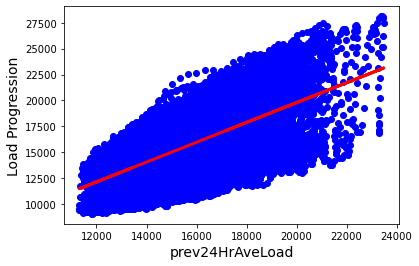

Mean squared error:  6059032.55740701
Mean Absolute Percentage Errror 14.965036376912133
Weights is %f, and Bais is %f (array([0.95813537]), 632.8332119539082)


In [13]:
# In the given example we are using the feature number 7 to train the regression model

OneF_reg = one_feature_regression(input_features,target_values,7)    # Fearure is prev24HrAvgLoad


w = OneF_reg.coef_
b = OneF_reg.intercept_

# Weights of regress

print('Weights is %f, and Bais is %f', (w, b))    # 1 feature: 1 weight

# This function provides the single feature regress along with the value of loss and MAPE. 
# The x-axis give the name of feature used for regression.


# Find the one feature with mininmim MSE or MAPE. (Hint: simply substitute the f index in the above function calling.

## Q2. Predict `y` using a specified subset of features from `x`

The function **feature_subset_regression** is just like **one_feature_regression**, but this time uses a list of features `flist`.

In [14]:
def feature_subset_regression(x,y,flist):

    '''
    x -> input features
    y -> target values

    flist -> subset of feature for model training: pass list of the feature intex  [6,7] for feature number 7 and 8
    '''


    if len(flist) < 1:
        print("Need at least one feature")
        return
    for f in flist:
        if (f < 0) or (f > 26):
            print("Feature index is out of bounds")
            return
    regr = linear_model.LinearRegression()
    x1 = x[:,flist]
    regr.fit(x1, y)
    # Make predictions using the model
    y_pred = regr.predict(x1)

    print("Mean squared error: ", mean_squared_error(y, y_pred))
    print('Mean Absolute Percentage Errror', mean_absolute_percentage_error(y, y_pred)*100)
    return regr

### (a) Using the *feature_subset_regression*, calculate MSE, w and b using features #7 (P_D_S_hour_l) and #8 (prev24HrAveLoad). (b) Calculate MSE and MAPE using all 8 features?

In [15]:
# In this example we will use the feature number 6,7,8,9 and for regressing


mul_f = feature_subset_regression(input_features, target_values, [5,6,7,8])   # rememeber index starts for 0

# With multiple feature feature the loss function starts to decrease. 


w = mul_f.coef_
b = mul_f.intercept_

# Weights of regress

print('Weights is %f, and Bais is %f', (w, b))   # four feature four weights


Mean squared error:  976633.829681334
Mean Absolute Percentage Errror 4.686824201868077
Weights is %f, and Bais is %f (array([ 0.46314764,  0.46278269,  0.4967366 , -0.43293858]), 153.7483479206203)


# Use all 27 Features for regression analysis

In [16]:
# Using all features for regression

feature_list = [i for i in range(27)]

reg = feature_subset_regression(input_features, target_values, feature_list)


w = reg.coef_
b = reg.intercept_

# Weights of regress

print('Length Weights is %f, and Bais is %f', (len(w), b))   # 27 feature four weights

print('---------------------------------------------')

print('Length Weights is %f, and Bais is %f', (w, b))


Mean squared error:  571703.09101272
Mean Absolute Percentage Errror 3.713353901065962
Length Weights is %f, and Bais is %f (27, 459.1705581532133)
---------------------------------------------
Length Weights is %f, and Bais is %f (array([ 5.47517470e+00,  2.79352589e+00,  1.31950104e+01, -1.34976706e+02,
        3.10126259e+02,  3.11938564e-01,  6.13882061e-01,  2.12141814e+00,
       -7.92006807e-01,  9.27027003e-01, -1.37502132e+00, -1.11466140e-04,
        1.80822147e-04,  2.39789257e-01, -4.21593458e-01, -2.18867246e+00,
        2.28940788e-05, -2.40510820e-01,  1.08456377e+00, -1.14094287e-04,
        8.33604110e-01, -2.40569028e+00, -8.39153315e-01,  1.09890372e+01,
       -6.82829482e+01, -6.47684817e-01,  6.13644296e+00]), 459.1705581532133)


## Q3. Splitting the data into a training and test set

In the experiments above, every model was fit to the *entire* data set and its mean squared error was evaluated on this same data set. This methodology would not, in general, yield accurate estimates of future error. In this specific case, however, the discrepancy might not be too bad because the data set is quite large relative to the number of features.

To investigate this further, we define a procedure **split_data** that partitions the data set into separate training and test sets. It is invoked as follows:

* `trainx, trainy, testx, testy = split_data(n_train)`

Here:
* `n_train` is the desired number of training points
* `trainx` and `trainy` are the training points and response values
* `testx` and `testy` are the test points and response values

The split is done randomly, but the random seed is fixed, and thus the same split is produced if the procedure is called repeatedly with the same `n_train` parameter.

In [17]:
def split_data(n_train):
    if (n_train < 0) or (n_train > 48000):
        print("Invalid number of training points")
        return
    np.random.seed(0)
    perm = np.random.permutation(48000)
    training_indices = perm[range(0,n_train)]
    test_indices = perm[range(n_train,48000)]
    trainx = input_features[training_indices,:]
    trainy = target_values[training_indices]
    testx = input_features[test_indices,:]
    testy = target_values[test_indices]
    return trainx, trainy, testx, testy

Using the **split_data** procedure to partition the data set, compute the training MSE and test MSE when fitting a regressor to *all* features, for the following training set sizes:
* `n_train = 20000`
* `n_train = 25000`
* `n_train = 30000`
* `n_train = 40000`

In [18]:
n_train = 40000

# splitting the data
xtrain, ytrain, xtest, ytest =split_data(n_train)

# Generating the model
reg = linear_model.LinearRegression()

# Model training
reg.fit(xtrain, ytrain)

# Prediction

y_pred = reg.predict(xtest)

# MSE
mse = mean_squared_error(ytest, y_pred)
MAPE = mean_absolute_percentage_error(ytest, y_pred)*100

print('For Training size=%d, the test MSE is :%f, and MAPE is :%f', n_train, mse, MAPE)


# You can change the values of n_train and see the impact on MSE and MAPE

For Training size=%d, the test MSE is :%f, and MAPE is :%f 40000 555848.7090304256 3.685370838231248


## Q4: Apply Min-Max feature scaling to normalize the data and caluclate the MSE and MAPE on features

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled=scaler.fit_transform(input_features)



# training the model using scaled features

reg_scaled = feature_subset_regression(x_scaled, target_values, feature_list) 

# function defined previously for using subset and all features for regression.



Mean squared error:  571703.0910127201
Mean Absolute Percentage Errror 3.71335390107043


## Q5: Use test train split to divide the dataset in 70-30 and applying the decision tree and Random forest algorithms using sklearn library

Find the MSE and MAPE for both decision tree and random forest and compare it with linear regression and Plot the actual and predicted results of first 168 hours (weekly plot)

In [20]:
# Importing the libraries for decision tree and random forest for sklearn

from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor
import time

# Decision Tree Using sklearn

In [21]:
# Creating the test train split using sklearn library

# split is kept 70 - 30

# the data is not shaffled

x_train, x_test, y_train, y_test = train_test_split(input_features,target_values, test_size=0.3, 
                                                        random_state=42, shuffle=False)  

In [22]:
'''
DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, 
                        min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                        max_features=None, random_state=None, max_leaf_nodes=None, 
                        min_impurity_decrease=0.0, ccp_alpha=0.0)

'''

# creating a DF using the default parameters

DT = DecisionTreeRegressor()    # Change parameter, write the parameter name and values in the function called

# Model training

start = time.time()
DT = DT.fit(x_train, y_train)
stop = time.time()

dt_time = stop-start

# model prediction

y_pred_dt = DT.predict(x_test)

# model evaluation

print('Model Performance')

print('-----------------------------------------------------------')

print('Decision Tree convergence time in seconds:', dt_time)

print('-----------------------------------------------------------')

print('MSE:', mean_squared_error(y_test, y_pred_dt))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred_dt)*100)



Model Performance
-----------------------------------------------------------
Decision Tree convergence time in seconds: 1.3246309757232666
-----------------------------------------------------------
MSE: 455602.34280936455
MAPE: 3.1657550520363333


To further optimise the model and improve performance, the parameters of the model are change.

The process of obtaining the optimal model parameter is termed as hyperparameter tuning.

# Weekly Plot of Decsion Tree 

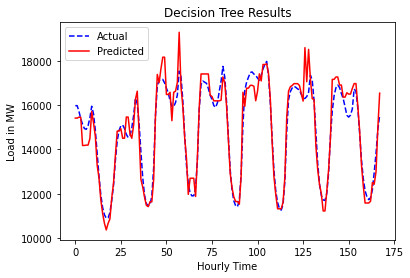

In [23]:
# Plot the the results of actual vs predicted values

plt.plot(y_test[1800:1968], 'b--', label='Actual')
plt.plot(y_pred_dt[1800:1968], 'r-', label='Predicted')
plt.title('Decision Tree Results')
plt.xlabel('Hourly Time')
plt.ylabel('Load in MW')

plt.legend(loc='upper left')

figsize=(20,16)

# Random Forest Uisng Sklearn

In [24]:
''' 
RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, 
                    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, 
                    min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                    verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
'''


# Parameters for random forest classifier
# In this case, instead of using the default parameter, some of the parameter are been changed
# Further, the parameter tuning is done using either grid search, random search or other techniques


from random import random
from tkinter import N
from sklearn.ensemble import RandomForestRegressor


# create the model

rf = RandomForestRegressor(n_estimators=200, max_depth=30, n_jobs=-1, random_state=42)

# train the model

start = time.time()

rf.fit(x_train, y_train)

stop = time.time()

rf_time = stop-start
# model predction

y_pred_rf = rf.predict(x_test)



# model evaluation

print('Model Performance')

print('-----------------------------------------------------------')

print('Random Forest Convergence time in seconds:', rf_time)

print('-----------------------------------------------------------')

print('MSE:', mean_squared_error(y_test, y_pred_rf))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred_rf)*100)


Model Performance
-----------------------------------------------------------
Random Forest Convergence time in seconds: 15.545804262161255
-----------------------------------------------------------
MSE: 172318.2429601801
MAPE: 2.0337108490351374


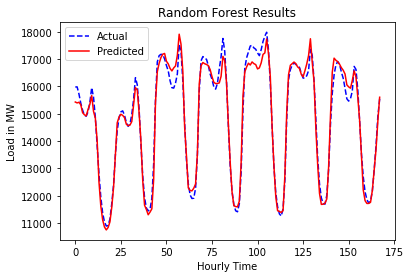

In [25]:
# Plot the the results of actual vs predicted values

plt.plot(y_test[1800:1968], 'b--', label='Actual')
plt.plot(y_pred_rf[1800:1968], 'r-', label='Predicted')
plt.title('Random Forest Results')
plt.xlabel('Hourly Time')
plt.ylabel('Load in MW')

plt.legend(loc='upper left')

figsize=(20,16)

For the above results, it is clearly evident that Random Forest performs better the DT and Linear Regression of this particular problem. 

The original dataset is expended to obtain 27 feature vecotors and analysis is done. Using linear regression, a short investigation is done on 
the impact of different feature set on the performace of model

Decision Tress and Random Forest models are trained and evaluated using the 27 feature and results shows the performace of RF is better then DT.


However, in machine learning the input feature set has a huge impact on the performance of the model. Therefore, we will perform an analysis on the
feature importance and overall impact on the model performmance. Further, will smaller feature set the model convergence can be reduced.

# Features Importance Mechanism

Feature Elemination or Dimensiontality Reduction


- The idea is to identify the most useful features for the dataset
- Use the best features for model training to reduce the complexity and improve the performance

In [26]:
# Random forest for obtaining the feature importance


# create RF model

rf_1 = RandomForestRegressor(n_estimators=200, max_depth=30, n_jobs=-1, random_state=42)

# parameter are same as previous example for fair comparision

rf_1.fit(input_features, target_values)


RandomForestRegressor(max_depth=30, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [27]:
print('Features:', features)

print('--------------------------------------')
print('Number of features:', len(features))

Features: ['DryBulb', 'DewPoint', 'Hour', 'Weekday', 'IsWorkingDay', 'P_W_S_hour_l', 'P_D_S_hour_l', 'prev24HrAveLoad', 'weekly_rollingavg', 'weekly_std', 'daily_std', 'weekly_varience', 'daily_varience', 'weekly_median', 'daily_meadian', '48_hour_mean', '48_hour_variance', '48_hour_std', '72_hour_mean', '72_hour_variance', '72_hour_std', '12_hours_temp_mean', '24_hour_temp_mean', '12_hours_temp_std', '24_hour_temp_std', '12_hours_temp_var', '24_hour_temp_var']
--------------------------------------
Number of features: 27


In [28]:
# !pip install scikit-plot
!pip install yellowbrick

Text(0, 0.5, 'Gini Importance')

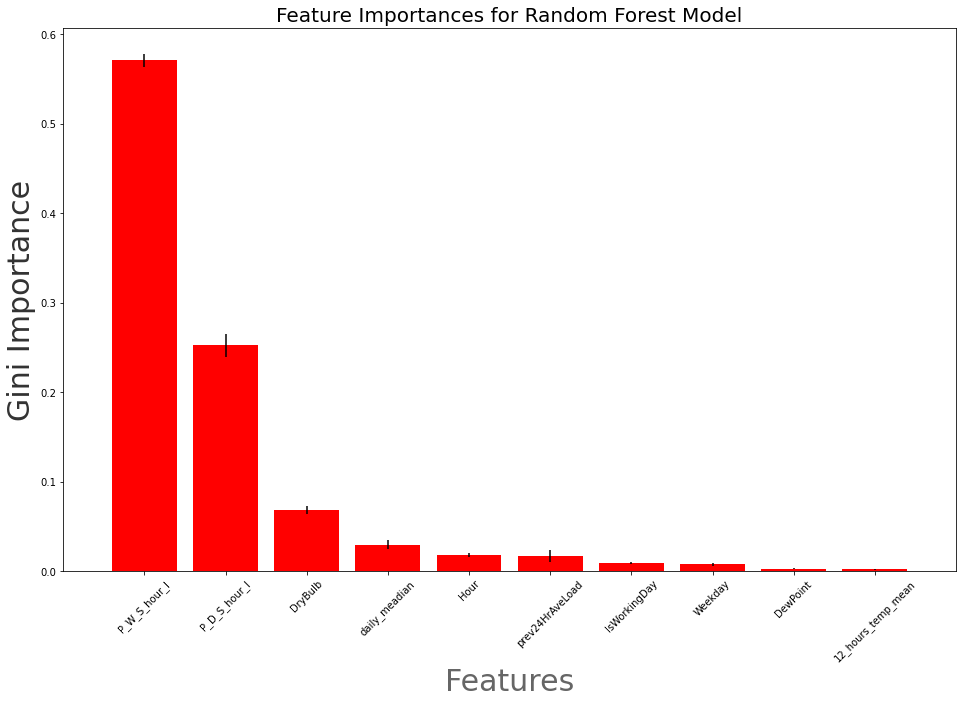

In [29]:
import scikitplot as skplt

skplt.estimators.plot_feature_importances(rf_1, feature_names=features,
                                            max_num_features= 10,
                                            x_tick_rotation=45,
                                            ax=None, figsize=(16,10))
plt.title('Feature Importances for Random Forest Model', fontsize=20)
plt.xlabel("Features", fontsize=30,color='0.4')
plt.ylabel("Gini Importance", fontsize=30,color='0.2')


# Selecting the Features based on the Importance

In [30]:
dataset_reduced = dataset_new[['P_W_S_hour_l', 'P_D_S_hour_l', 'DryBulb', 'daily_meadian', 'Hour', 'prev24HrAveLoad', 'IsWorkingDay', 'Weekday', 'DewPoint', '12_hours_temp_mean']]
dataset_reduced

,P_W_S_hour_l,P_D_S_hour_l,DryBulb,daily_meadian,Hour,prev24HrAveLoad,IsWorkingDay,Weekday,DewPoint,12_hours_temp_mean
0,15138,14315,16,18298.5,24,17191.29167,1,4,3,4.083333
1,12230,13415,15,18298.5,1,17223.41667,1,5,0,3.916667
2,11534,12990,14,18298.5,2,17255.37500,1,5,1,3.833333
3,11038,12832,13,18298.5,3,17287.08333,1,5,0,3.416667
4,10777,12866,12,18298.5,4,17318.16667,1,5,-1,3.000000
...,...,...,...,...,...,...,...,...,...,...
49828,9408,9990,58,13773.0,4,13135.45833,1,2,53,56.000000
49829,9473,9972,57,13773.0,5,13147.91667,1,2,53,55.666667
49830,9740,10171,56,13773.0,6,13192.70833,1,2,52,55.166667
49831,10039,10539,56,13773.0,7,13297.83333,1,2,52,54.583333


# Selected Feature based model

In [31]:
# Preparing the model for trainng



reduced_features = np.array(dataset_reduced)         # Selected Features
target_values = np.array(dataset_new['target_variable'])                       # Output


print('Shape of the Input data:', reduced_features.shape)
print('Shape of the target variable:', target_values.shape)


print('Data type of the input features:', reduced_features.dtype)

Shape of the Input data: (49833, 10)
Shape of the target variable: (49833,)
Data type of the input features: float64


In [32]:
# Data splitting in test train split

x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(reduced_features,target_values, test_size=0.3, 
                                                        random_state=42, shuffle=False)

DT_m = DecisionTreeRegressor()    # Change parameter, write the parameter name and values in the function called

# Model training

start = time.time()
DT_m.fit(x_train_reduced, y_train_reduced)
stop = time.time()

dt_time_r = stop-start

# model prediction

y_pred_dt_r = DT_m.predict(x_test_reduced)

# model evaluation

print('Model Performance')

print('-----------------------------------------------------------')

print('Decision Tree convergence time in seconds:', dt_time_r)

print('-----------------------------------------------------------')

print('MSE:', mean_squared_error(y_test_reduced, y_pred_dt_r))
print('MAPE:', mean_absolute_percentage_error(y_test_reduced, y_pred_dt_r)*100)

Model Performance
-----------------------------------------------------------
Decision Tree convergence time in seconds: 0.3966331481933594
-----------------------------------------------------------
MSE: 431393.73906354513
MAPE: 3.0585081949702606


# Random Forest with selected features

In [33]:
# Creating the test train split using sklearn library

# split is kept 70 - 30

# the data is not shaffled

x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(reduced_features,target_values, test_size=0.3, 
                                                        random_state=42, shuffle=False)




# create the model

rf_m = RandomForestRegressor(n_estimators=200, max_depth=30, n_jobs=-1, random_state=42)

# train the model

start = time.time()

rf_m.fit(x_train_reduced, y_train_reduced)

stop = time.time()

rf_time_m = stop-start
# model predction

y_pred_rf_r = rf_m.predict(x_test_reduced)



# model evaluation

print('Model Performance')

print('-----------------------------------------------------------')

print('Random Forest Convergence time in seconds:', rf_time_m)

print('-----------------------------------------------------------')

print('MSE:', mean_squared_error(y_test_reduced, y_pred_rf_r))
print('MAPE:', mean_absolute_percentage_error(y_test_reduced, y_pred_rf_r)*100)


Model Performance
-----------------------------------------------------------
Random Forest Convergence time in seconds: 5.007343530654907
-----------------------------------------------------------
MSE: 166237.0935008653
MAPE: 1.9976523752207271


With feature Selection, the convergence time is significantly reduced with improved model performace. To further improve the result following method can be adopted:

- Perform hyperparameter tuning to obtain the optimal parameters for model training
- Use feature elemination mechanism to select the best subset of features
- Use neural netowrk or other deep learning techniques 


These is always a tradeoff between model performance, complexity, and convergence time which varies with applications.

# Recursive Feature Elimination (RFE) for Feature Selection in Python

- model used is RF
- For Details please follow the link: https://machinelearningmastery.com/rfe-feature-selection-in-python/

c:\Users\ahsan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\ahsan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\ahsan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\ahsan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\ahsan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\ahsan\Anaconda3\lib\s

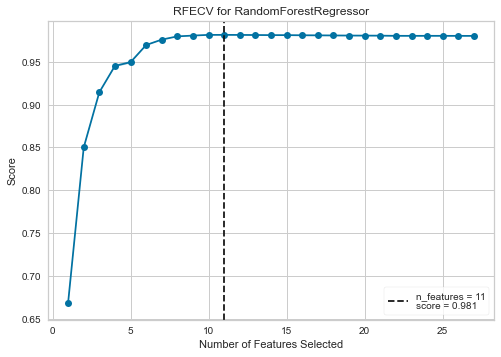

<AxesSubplot:title={'center':'RFECV for RandomForestRegressor'}, xlabel='Number of Features Selected', ylabel='Score'>

In [260]:
# A short flaver to show the automated feature elimination mechanism.

from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV



cv = StratifiedKFold(2)   # Here the cross-validation mechanism is used and data argument value is the number of folds

vis = RFECV(rf_1, cv= cv)

vis.fit(input_features, target_values)

vis.show()


In [37]:
import session_info
session_info.show()

In [266]:
%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p wget,pandas,numpy,watermark,sklearn,matplotlib,keras

# date
print (" ")
%watermark -u -n -t -z 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

wget      : 3.2
pandas    : 1.1.5
numpy     : 1.21.2
watermark : 2.3.1
sklearn   : 1.0.2
matplotlib: 3.3.4
keras     : 2.9.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 16
Architecture: 64bit

 
Last updated: Fri Aug 26 2022 16:46:10GMT Summer Time

